In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
import sys
sys.path.append('../')
sys.path.append('../support/')
sys.path.append('../lung_segmentation/')
import os
from preprocessing import *
from ct_reader import *
from scipy.ndimage import morphology 
from skimage import measure
from tqdm import tqdm
import time
from os.path import join, basename, isfile
from multiprocessing import Pool
from scipy.ndimage import label
import scipy.ndimage.filters as filters
from glob import glob
from paths import *
import functools

from scipy.linalg import norm
from scipy.ndimage.filters import gaussian_filter, laplace
import pandas as pd

In [13]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [14]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(join(path, pslice)) 
              for pslice in glob(join(path, '*.dcm'))]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [15]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [16]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [17]:
def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [18]:
def load_data(path):    
    ct_scan = load_scan(path)
    patient = get_pixels_hu(ct_scan)
    patient, spacing = resample(patient, ct_scan, SPACING)
    
    mask = segment_lung_mask(patient)
    mask = morphology.binary_fill_holes(
        morphology.binary_dilation(
            morphology.binary_fill_holes(mask > 0), 
            iterations=4)
    )

    return patient, mask

In [20]:
glob(join(PATH['STAGE_DATA'], '*'))[0]

'/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/NEW_STAGE/DATA/63248fdafd2df302b57a479289d76105'

In [19]:
patient, mask = load_data()

IndexError: list index out of range

In [16]:
'/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/TRAIN/0015ceb851d7251b8f399e39779d1e7d/'

'/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/TRAIN'

In [ ]:
def read_ct(path, ret_ct_scan=False, ret_xy_spacing=False):
    patient = read_ct_scan(path)
    if ret_ct_scan:
        return get_pixels_hu(patient), patient
    if ret_xy_spacing:
        return get_pixels_hu(patient), patient.GetSpacing()[0]
    
    return get_pixels_hu(patient)

In [4]:
SPACING = array([1., 1., 1.])
ISOLATED_THRESHOLD = -600
DOT_ENHANCED_THRESHOLD = 6
BOTTOM = 4
TOP = 16
CPU = 24
FILTERS_AMOUNT = 6
ISOLATED_MIN_VOLUME = 9
ISOLATED_MAX_VOLUME = 500
JUXTAVASCULAR_MIN_VOLUME = 9
JUXTAPLEURAL_MIN_VALUME = 1

In [22]:
def get_scales(bottom=BOTTOM, top=TOP, 
               amount=FILTERS_AMOUNT):
    radius = (top / bottom) ** (1. / (amount - 1))
    sigmas = [bottom / 4.]
    for i in range(amount - 1):
        sigmas.append(sigmas[0] * (radius ** i + 1))
    return sigmas

In [6]:
def load_data(patients, is_LUNA=False):    
    masks_pats = []
    for pat in patients:
        _patient, ct_scan = read_ct(pat, True)
        if is_LUNA:
            _mask = load(join(PATH['DATA_OUT'], basename(pat).split('.mhd')[0] + '.npy')) > 0
        else:
            _mask = load(join(PATH['DATA_OUT'], basename(pat) + '.npy')) 
        _patient, spacing = resample(_patient, ct_scan, SPACING)
        _mask, spacing_xy = resample(_mask, ct_scan, SPACING)
        _mask = morphology.binary_fill_holes(morphology.binary_dilation(morphology.binary_fill_holes(_mask > 0), 
                                                                 iterations=4))
        if is_LUNA:
            candidates = pd.read_csv(join(PATH['LUNA_CSV'],'candidates.csv'))
            candidates = candidates[candidates.seriesuid == basename(pat).split('.mhd')[0]]
            _cands = []
            for i,cand in (candidates.iterrows()):
                _cands.append(flipud(asarray([cand.coordX,
                                              cand.coordY,
                                              cand.coordZ]) 
                                     - asarray(ct_scan.GetOrigin())).astype(int))
            _cands = asarray(_cands)
        else:
            _cands = None

        masks_pats.append((_mask, _patient, _cands))
    return masks_pats

In [7]:
def apply_enhs_filters(masks_pats, include_plane=False):
    enhs = []
    sigmas = get_scales()
    for mask, patient, cands in masks_pats:
        start = time.time()

        _enh_dot = zeros(mask.shape)
        _enh_line = zeros(mask.shape)
        _enh_plane = zeros(mask.shape)

        z_dot = list()
        z_line = list()
        z_plane = list()
        divs = list()

        for i, sigma in enumerate(sigmas):

            filtered = gaussian_filter(patient, sigma=sigma)
            grad = gradient(filtered * mask)

            axis = [[0, 1, 2], [1, 2], [2]]
            hess = [gradient(deriv, axis=j) 
                    for i, deriv in enumerate(grad) 
                    for j in axis[i]]

        #   [(0, xx), (1, xy), (2, xz), (3, yy), (4, yz), (5, zz)]
        #   x, y, z -> 3, 3, x, y, z -> 3, 3, N

            coords = where(mask)
            for j in range(len(hess)):
                hess[j] = hess[j][coords]

            hess = asarray([[hess[0], hess[1], hess[2]],
                            [hess[1], hess[3], hess[4]],
                            [hess[2], hess[4], hess[5]]])


            with Pool(CPU) as pool:
                eigs = pool.map(linalg.eigvalsh, [hess[:, :, i] for i in range(hess.shape[-1])])


            sigma_sqr = sigma ** 2
            z_dot.append([sigma_sqr * (eig_val[2] ** 2) / abs(eig_val[0]) 
                          if eig_val[0] < 0 
                          and eig_val[1] < 0 
                          and eig_val[2] < 0 
                          else 0
                          for eig_val in eigs])

            z_line.append([sigma_sqr * abs(eig_val[1]) 
                           * (abs(eig_val[1]) - abs(eig_val[2])) 
                           / abs(eig_val[0]) 
                           if eig_val[0] < 0 
                           and eig_val[1] < 0 
                           else 0
                           for eig_val in eigs])

            if include_plane:
                z_plane.append([sigma_sqr * (abs(eig_val[0]) - abs(eig_val[1]))
                                if eig_val[0] < 0 
                                else 0
                                for eig_val in eigs])


        _enh_dot[coords] = asarray(z_dot).max(axis=0)
        _enh_line[coords] = asarray(z_line).max(axis=0)
        
        end = time.time()
        print(end - start)
        if include_plane:
            _enh_plane[coords] = asarray(z_plane).max(axis=0)
        if include_plane:
            enhs.append((_enh_dot, _enh_line, _enh_plane))
        else:
            enhs.append((_enh_dot, _enh_line))
    return enhs

In [20]:
def divergence(sigma, patient):
    grad = asarray(gradient(patient))
    grad /= norm(grad, axis=0) + 1e-3
    grad = [gaussian_filter(deriv, sigma=sigma) for deriv in grad]
    return sum([gradient(el, axis=i) 
                for i, el in enumerate(grad)], axis=0)

In [28]:
def maxima_divergence(patient, mask, sigmas):
    with Pool(CPU) as pool:
        divs = pool.map(
            functools.partial(divergence, 
                              patient=patient), 
            sigmas
        )
    divs = -1 * asarray(divs) * mask 
    return divs.max(axis=0)

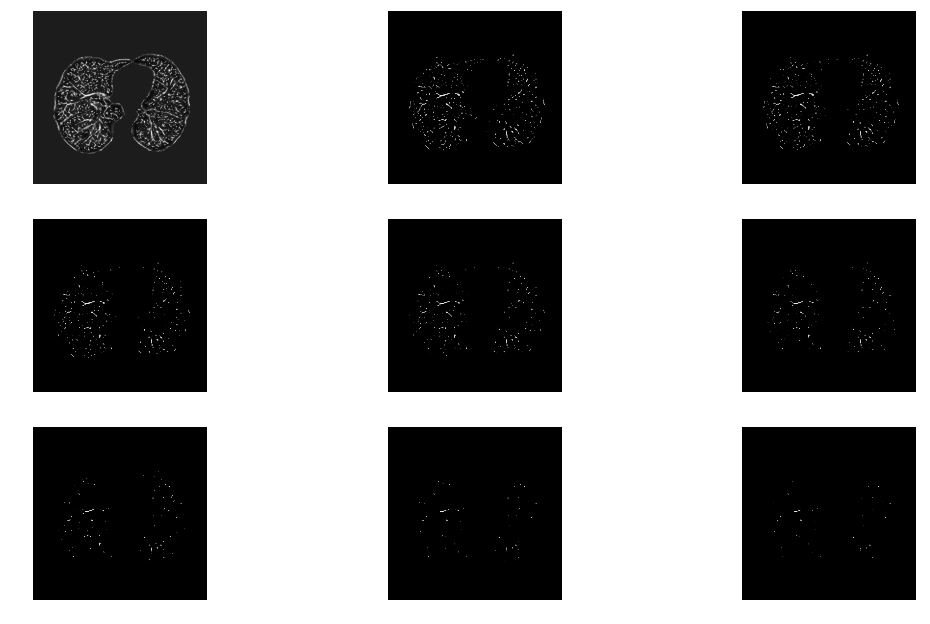

In [73]:
sigmas = get_scales()
mdng = maxima_divergence(patient, mask, sigmas)

mdng_max = mdng.max()
mdng_std = mdng.std()

figure(figsize=(18, 18))
subplot(5, 3, 1) 
imshow(mdng[mdng.shape[0] // 2])
axis('off')
for i, threshold in enumerate(arange(7, 3, -.5)):
    subplot(5, 3, i + 2) 
    imshow((mdng * (mdng >= mdng_max 
                    - threshold * mdng_std))[mdng.shape[0] // 2])
    axis('off')
show()

isolated nodules

In [11]:
def is_in(colour, labe, dng_colours):
    if colour in dng_colours:
        return labe == colour

In [12]:
def get_isol(patient, mask, enh_dot, divs):
    isolated = (patient > -600) * (mask > 0) * (enh_dot < 6) 
    labe, _ = label(isolated)
    volumes = bincount(labe.flatten())
    dng_colours = unique(labe * (divs > dng_thresh1))
    colours = where((volumes > ISOLATED_MIN_VOLUME) 
                & (volumes < ISOLATED_MAX_VOLUME))[0]
    isolated = zeros(isolated.shape)
    iso_nodules_num = 0
    for colour in colours:
        if colour in dng_colours:
            iso_nodules_num+=1
            isolated += labe == colour
    return isolated,iso_nodules_num

In [37]:
def get_pure_isol(patient, mask, enh_dot):
    isolated = (patient > -600) * (mask > 0) * (enh_dot < 6) 
    labe, iso_nodules_num = label(isolated)
    volumes = bincount(labe.flatten())
    colours = where((volumes > ISOLATED_MIN_VOLUME) 
                & (volumes < ISOLATED_MAX_VOLUME))[0]
    
    isolated = zeros(isolated.shape).astype(bool)
    for colour in colours:
        isolated |= labe == colour
        
    return isolated, iso_nodules_num

In [38]:
def get_isol(patient, mask, enh_dot, divs):
    isolated = (patient > -600) * (mask > 0) * (enh_dot < 6) 
    labe, _ = label(isolated)
    volumes = bincount(labe.flatten())
    dng_colours = unique(labe * (divs > dng_thresh1))
    colours = where((volumes > ISOLATED_MIN_VOLUME) 
                & (volumes < ISOLATED_MAX_VOLUME))[0]
    is_in_dng = functools.partial(is_in, dng_colours=dng_colours, labe=labe)
    with Pool(CPU) as pool:
        isolated = pool.map(is_in_dng, colours)
        
    isolated = list(filter(lambda x: x is not None, isolated))
    iso_nodules_num = len(isolated)  
    return asarray(isolated).sum(axis=0), iso_nodules_num

In [39]:
def get_j_va(patient, mask, enh_line, divs, iso):
    juxtavascular = (patient > -600) * (mask > 0) * (enh_line > 150)
    juxtavascular = juxtavascular * (divs <= dng_thresh1)
    j_va_candidates = (divs > dng_thresh1) * (1 - juxtavascular) * (1 - iso)
#     ????? WHY ARE YOU LABELING DIVS ??????
    labe, _ = label(divs > dng_thresh1)

    volumes = bincount(labe.flatten())
    dng_colours = unique(labe * j_va_candidates)
    colours = where((volumes > JUXTAVASCULAR_MIN_VOLUME) 
                    & (volumes < ISOLATED_MAX_VOLUME))[0]
    j_va = zeros(juxtavascular.shape)
    j_va_nodules_num = 0
    for colour in colours:
        if colour in dng_colours:
            j_va_nodules_num+=1
            j_va += labe == colour
    return j_va, j_va_nodules_num

In [52]:
def get_pure_j_va(patient, mask, enh_line, iso):
    juxtavascular = (patient > -600) * (mask > 0) * (enh_line > 150)
    j_va_candidates = (1 - juxtavascular) * (1 - iso)
    labe, j_va_nodules_num = label(j_va_candidates)

    volumes = bincount(labe.flatten())
    colours = where((volumes > JUXTAVASCULAR_MIN_VOLUME) 
                    & (volumes < ISOLATED_MAX_VOLUME))[0]
    j_va = zeros(juxtavascular.shape).astype(bool)
    for colour in colours:
        j_va |= labe == colour
    
    return j_va, j_va_nodules_num

In [41]:
def get_j_va(patient, mask, enh_line, divs, iso):
    juxtavascular = (patient > -600) * (mask > 0) * (enh_line > 150)
    juxtavascular = juxtavascular * (divs <= dng_thresh1)
    j_va_candidates = (divs > dng_thresh1) * (1 - juxtavascular) * (1 - iso)
    labe, _ = label(divs > dng_thresh1)

    volumes = bincount(labe.flatten())
    dng_colours = unique(labe * j_va_candidates)
    colours = where((volumes > JUXTAVASCULAR_MIN_VOLUME) 
                    & (volumes < ISOLATED_MAX_VOLUME))[0]
    is_in_dng = functools.partial(is_in, dng_colours=dng_colours, labe=labe)
    with Pool(CPU) as pool:
        j_va = pool.map(is_in_dng, colours)
        
    j_va = list(filter(lambda x: x is not None, j_va))
    j_va_nodules_num = len(j_va)  
    return asarray(j_va).sum(axis=0), j_va_nodules_num

In [42]:
def get_j_pl(patient, mask, enh_dot, divs):
    fixed_mask = morphology.binary_erosion(mask > 0, iterations=4)
    border_mask = fixed_mask * (1 - morphology.binary_erosion(fixed_mask > 0, iterations=4))
    juxtapleural = (patient > -400) * (border_mask > 0) * (enh_dot > 4)

    labe, _ = label(juxtapleural)
    volumes = bincount(labe.flatten())
    dng_colours = unique(labe * (divs > dng_thresh2))
    colours = where((volumes > JUXTAPLEURAL_MIN_VALUME) 
                    & (volumes < ISOLATED_MAX_VOLUME))[0]
    j_pl = zeros(juxtapleural.shape)
    j_pl_num = 0
    for colour in colours:
        if colour in dng_colours:
            j_pl_num+=1
            j_pl += labe == colour
    return j_pl, j_pl_num

In [1]:
def get_pure_j_pl(patient, mask, enh_dot):
    
#     !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     
#     IF NO DILATION IN STILL STILL ERRONEUS 
#     UNCOMMENT ANYWAY
#     fixed_mask = morphology.binary_erosion(mask > 0,iterations=4)
# 
#     !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    border_mask = fixed_mask * (1 - morphology.binary_erosion(fixed_mask > 0,iterations=4))
    juxtapleural = (patient > -400) * (border_mask > 0) * (enh_dot > 4)

    labe, j_pl_num = label(juxtapleural)
    volumes = bincount(labe.flatten())
    colours = where((volumes > JUXTAPLEURAL_MIN_VALUME) 
                    & (volumes < ISOLATED_MAX_VOLUME))[0]
    j_pl = zeros(juxtapleural.shape).astype(bool)
    for colour in colours:
        j_pl |= labe == colour
    return j_pl, j_pl_num

In [62]:
def get_j_pl(patient, mask, enh_dot, divs):
    fixed_mask = morphology.binary_erosion(mask > 0,iterations=4)
    border_mask = fixed_mask * (1 - morphology.binary_erosion(fixed_mask > 0,iterations=4))
    juxtapleural = (patient > -400) * (border_mask > 0) * (enh_dot > 4)

    labe, _ = label(juxtapleural)
    volumes = bincount(labe.flatten())
    dng_colours = unique(labe * (divs > dng_thresh2))
    colours = where((volumes > JUXTAPLEURAL_MIN_VALUME) 
                    & (volumes < ISOLATED_MAX_VOLUME))[0]
    is_in_dng = functools.partial(is_in, dng_colours=dng_colours, labe=labe)
    with Pool(CPU) as pool:
        j_pl = pool.map(is_in_dng, colours)
        
    j_pl = list(filter(lambda x: x is not None, j_pl))
    j_pl_num = len(j_pl)  
    return asarray(j_pl).sum(axis=0), j_pl_num

In [63]:
def get_nodules(patient, mask, enh, divs):
    """
    Here: 
    1 is for isolated
    2 is for j_va
    4 is for j_pl
    """
    iso, iso_num = get_isol(patient,mask,enh[0],divs)
    j_va, j_va_num = get_j_va(patient,mask,enh[1],divs,iso)
    j_pl, j_pl_num = get_j_pl(patient,mask,enh[0],divs)
    return 2 * j_va + iso + 4 * j_pl, (iso_num, j_va_num, j_pl_num)

In [64]:
def get_pure_nodules(patient, mask, enh):
    """
    Here: 
    1 is for isolated
    2 is for j_va
    4 is for j_pl
    """
    iso, iso_num = get_pure_isol(patient, mask, enh[0])
    j_va, j_va_num = get_pure_j_va(patient, mask, enh[1], iso)
    j_pl, j_pl_num = get_pure_j_pl(patient, mask, enh[0])
    return 2 * j_va + iso + 4 * j_pl, (iso_num, j_va_num, j_pl_num)

In [65]:
# dng_thresh1 = .8
# dng_thresh2_space = linspace(.1, .3, num=4)

In [66]:
def compute_candidates(masks_pats, enhs, 
                       divs_list=None, pure_only=True):
    nodules = list()
    amounts = list()
    for mp, enh, div in tqdm(zip(masks_pats, enhs, divs_list)):
        if pure_only:
            n1, n1_num = get_pure_nodules(mp[1], mp[0], enh, div)
        else:
            n1, n1_num = get_nodules(mp[1], mp[0], enh, div)
        nodules.append(n1)
        amounts.append(n1_num)
    return nodules, amounts

In [72]:
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/TRAIN_ENHS'
patients = list(sorted(glob(join(PATH['DATA'],'*'))))
for i, patient in enumerate(patients):
    start = time.time()
        
    masks_pats = load_data([patient])
    enhs = apply_enhs_filters(masks_pats, 
                              include_plane=False)
    
    nodules, amounts = get_pure_nodules(masks_pats[0][1], 
                                        masks_pats[0][0], 
                                        enhs[0])
    
    save(join(path, basename(patient)), nodules.astype(int8))
    save(join(path, basename(patient) + 'amounts'), amounts)
    
    end = time.time()
    print('Patient id:\t%d\ttime:\t%.2f' % (i, end - start))

890.6220519542694


TypeError: Can't convert 'tuple' object to str implicitly

In [8]:
def compute_tp_rate(masks_pats, nodules, 
                    cands, amounts, 
                    dng_thresh1, dng_thresh2):
    tp_rates = list()
    for mpc, pats_nodules in tqdm(zip(masks_pats, nodules)):
        _, patient, cands = mpc

        tru = 0.0
        cands_lung = np.zeros(patient.shape)
        cands_lung[(cands.T[0], cands.T[1], cands.T[2])] = 1
        cands_lung = morphology.binary_dilation(cands_lung, iterations=4)
        cands_lung, num = label(cands_lung)
        cands_lung = pats_nodules * cands_lung
        tp_rates.append(unique(cands_lung).shape[0] / num)

    print('-'*30)
    print('\t\tISO\tPLUR')
    print('DNG thresholds:\t%.2f\t%.2f' % (dng_thresh1, dng_thresh2))
    print('Mean CPS:\t%.2f' % array(amounts).mean(axis=0).sum())
    print('Mean TP rate:\t%.2f' % array(tp_rates).mean())   